In [2]:
def gmsh_sphere(model, name: str):
    """
    Create a Gmsh model of a unit sphere and generate a surface mesh.
    This function creates a sphere (as a volume), then extracts its boundary surfaces,
    defines a physical group for them, and generates a 2D mesh.
    """
    model.add(name)
    model.setCurrent(name)

    sphere = model.occ.addSphere(0, 0, 0, 1)
    model.occ.synchronize()

    boundaries = model.getBoundary([(3, sphere)], oriented=False)
    boundary_tags = [b[1] for b in boundaries if b[0] == 2]

    model.add_physical_group(2, boundary_tags)

    model.mesh.generate(2)
    return model

In [3]:


import gmsh
from dolfinx.io import gmshio, XDMFFile
from mpi4py import MPI
import os


out_dir = "FEM_Convergence_old/meshes"
os.makedirs(out_dir, exist_ok=True)


mesh_sizes = [0.013, 0.0145, 0.016, 0.019, 0.0225, 0.035, 0.055, 0.112]

mesh_files = []
for ms in mesh_sizes:
    gmsh.initialize()
    gmsh.option.setNumber("General.Terminal", 0)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", ms)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", ms/2)
    model = gmsh.model()

    gmsh_sphere(model, f"Sphere_ms{ms:.3f}")
    msh_fname = os.path.join(out_dir, f"sphere_surface_ms{ms:.3f}.msh")
    gmsh.write(msh_fname)
    mesh, cell_tags, facet_tags = gmshio.model_to_mesh(model, MPI.COMM_WORLD, 0)
    gmsh.finalize()
    xdmf_fname = msh_fname.replace(".msh", ".xdmf")
    with XDMFFile(MPI.COMM_WORLD, xdmf_fname, "w") as xdmf:
        xdmf.write_mesh(mesh)
    mesh_files.append((ms, xdmf_fname))

print("Generated meshes:")
for ms, fname in mesh_files:
    print(f"  mesh_size = {ms:.3f} -> {fname} (+ corresponding .msh)")

Generated meshes:
  mesh_size = 0.013 -> FEM_Convergence_old/meshes/sphere_surface_ms0.013.xdmf (+ corresponding .msh)
  mesh_size = 0.015 -> FEM_Convergence_old/meshes/sphere_surface_ms0.015.xdmf (+ corresponding .msh)
  mesh_size = 0.016 -> FEM_Convergence_old/meshes/sphere_surface_ms0.016.xdmf (+ corresponding .msh)
  mesh_size = 0.019 -> FEM_Convergence_old/meshes/sphere_surface_ms0.019.xdmf (+ corresponding .msh)
  mesh_size = 0.022 -> FEM_Convergence_old/meshes/sphere_surface_ms0.022.xdmf (+ corresponding .msh)
  mesh_size = 0.035 -> FEM_Convergence_old/meshes/sphere_surface_ms0.035.xdmf (+ corresponding .msh)
  mesh_size = 0.055 -> FEM_Convergence_old/meshes/sphere_surface_ms0.055.xdmf (+ corresponding .msh)
  mesh_size = 0.112 -> FEM_Convergence_old/meshes/sphere_surface_ms0.112.xdmf (+ corresponding .msh)


In [4]:

import gmsh
import numpy as np
from mpi4py import MPI
import os

quality_results = {}

for ms, xdmf_fname in mesh_files:

    msh_fname = xdmf_fname.replace(".xdmf", ".msh")
    if not os.path.exists(msh_fname):
        raise RuntimeError(f"Could not find .msh file: {msh_fname}")


    gmsh.initialize()
    gmsh.option.setNumber("General.Terminal", 0)
    gmsh.merge(msh_fname)


    surfaces = gmsh.model.getEntities(dim=2)
    if len(surfaces) == 0:
        print(f"Warning: no 2D entities in {msh_fname}")
        gmsh.finalize()
        continue
    surf_tag = surfaces[0][1]


    elemTypes, elemTagsNested, _ = gmsh.model.mesh.getElements(2, surf_tag)

    flat_elemTags = []
    for sublist in elemTagsNested:
        flat_elemTags.extend(sublist)


    qualityType = "angleShape"
    qualities = gmsh.model.mesh.getElementQualities(flat_elemTags, qualityType)

    qm = np.array(qualities)
    Q_min  = qm.min()
    Q_max  = qm.max()
    Q_mean = qm.mean()
    quality_results[ms] = (Q_min, Q_max, Q_mean)
    print(f"Mesh size {ms:.3f}: Q_min={Q_min:.3f}, Q_max={Q_max:.3f}, Q_mean={Q_mean:.3f}")

    gmsh.finalize()

Mesh size 0.013: Q_min=0.000, Q_max=1.000, Q_mean=0.988
Mesh size 0.015: Q_min=0.000, Q_max=1.000, Q_mean=0.987
Mesh size 0.016: Q_min=0.001, Q_max=1.000, Q_mean=0.987
Mesh size 0.019: Q_min=0.000, Q_max=1.000, Q_mean=0.987
Mesh size 0.022: Q_min=0.000, Q_max=1.000, Q_mean=0.986
Mesh size 0.035: Q_min=0.001, Q_max=1.000, Q_mean=0.985
Mesh size 0.055: Q_min=0.000, Q_max=1.000, Q_mean=0.977
Mesh size 0.112: Q_min=0.000, Q_max=1.000, Q_mean=0.975


In [1]:

import numpy as np
from dolfinx.mesh import create_submesh
from dolfinx.io import XDMFFile
import os
from mpi4py import MPI


slice_dir = "FEM_Convergence_old/slices"
os.makedirs(slice_dir, exist_ok=True)

slice_mesh_files = []
for ms, xdmf_fname in mesh_files:


    with XDMFFile(MPI.COMM_WORLD, xdmf_fname, "r") as xdmf_in:
        mesh = xdmf_in.read_mesh()


    tdim = mesh.topology.dim
    mesh.topology.create_connectivity(tdim, 0)
    cell2vert = mesh.topology.connectivity(tdim, 0)
    coords = mesh.geometry.x
    num_cells = mesh.topology.index_map(tdim).size_local


    cell_tags = np.zeros(num_cells, dtype=bool)
    for c in range(num_cells):
        vertex_ids = cell2vert.links(c)
        pts = coords[vertex_ids]
        midpoint = pts.mean(axis=0)
        if midpoint[0] >= 0.0:
            cell_tags[c] = True


    cell_indices = np.nonzero(cell_tags)[0].astype(np.int32)



    submesh, cell_map, vert_map, geo_map = create_submesh(mesh, tdim, cell_indices)



    slice_fname = os.path.join(slice_dir, f"sphere_half_xpos_ms{ms:.3f}.xdmf")
    with XDMFFile(MPI.COMM_WORLD, slice_fname, "w") as xdmf_out:
        xdmf_out.write_mesh(submesh)

    slice_mesh_files.append((ms, slice_fname))

print("Created slice meshes:")
for ms, fname in slice_mesh_files:
    print(f"  mesh_size = {ms:.3f} → {fname}")

RuntimeError: No .xdmf files found in './meshes'

In [1]:

import numpy as np
import dolfinx
from mpi4py import MPI
from petsc4py import PETSc
import ufl
from dolfinx.io import XDMFFile
from dolfinx.fem import Function, functionspace, Constant, form
from dolfinx.fem.petsc import LinearProblem
import os
import re


mesh_sizes = [0.013, 0.0145, 0.016, 0.019, 0.0225, 0.035, 0.055, 0.112]
dt_list     = [1e-2, 1e-4]


base_sol_dir = "FEM_Convergence_old/solutions"
os.makedirs(base_sol_dir, exist_ok=True)


slice_mesh_files = []
slice_dir = "FEM_Convergence_old/slices"
for fname in os.listdir(slice_dir):
    if fname.endswith(".xdmf") and "sphere_half_xpos_ms" in fname:
        ms = float(re.search(r"ms([0-9\.]+)\.xdmf$", fname).group(1))
        if ms in mesh_sizes:
            slice_mesh_files.append((ms, os.path.join(slice_dir, fname)))


results_phi = {}
results_Q   = {}


gamma_s   = 10.0
r_s       = 0.001
Q0        = 0.05
alpha     = 1.0
Nf        = 17
Ns        = 20
v_const   = 1.0
freqs     = np.arange(1, 85, 5)[:Nf]
rng       = np.random.default_rng(42)
r0_sources = rng.uniform(-1.0, 1.0, size=(Ns, 3))
v_sources  = rng.uniform(-1.0, 1.0, size=(Ns, 3))

def phase_func(x, r0, vs, time):
    r_st = r0 + vs * time
    diff = x.T - r_st[np.newaxis, :]
    dist = np.linalg.norm(diff, axis=1)
    return dist / v_const

def pink_noise_signal(x, time):
    num_pts = x.shape[1]
    out = np.zeros(num_pts, dtype=np.float64)
    for f in freqs:
        f_term = f ** (-alpha)
        for s in range(Ns):
            Pi_vals = phase_func(x, r0_sources[s], v_sources[s], time)
            out += f_term * np.sin(2.0 * np.pi * f * (time + Pi_vals))
    norm_factor = Q0 / (len(freqs) * Ns)
    return norm_factor * out

def Q_callable(x, t_value):
    return pink_noise_signal(x, t_value)


for dt in dt_list:
    T = 1.0
    num_time_steps = int(T / dt)

    dt_dir = os.path.join(base_sol_dir, f"dt_{dt:.0e}")
    os.makedirs(dt_dir, exist_ok=True)


    for ms, slice_xdmf in slice_mesh_files:

        with XDMFFile(MPI.COMM_WORLD, slice_xdmf, "r") as xdmf_in:
            mesh = xdmf_in.read_mesh()


        V = functionspace(mesh, ("Lagrange", 1))


        t = Constant(mesh, 0.0)


        phi_nm1 = Function(V)
        phi_n   = Function(V)
        phi_np1 = Function(V)


        phi_n.x.array[:]   = 0.0
        phi_nm1.x.array[:] = 0.0


        num_local_dofs = V.dofmap.index_map.size_local
        u_ref_dofs = np.zeros((num_time_steps, num_local_dofs), dtype=np.float64)
        Qs_dofs    = np.zeros((num_time_steps, num_local_dofs), dtype=np.float64)


        Q_function = Function(V)


        u_trial = ufl.TrialFunction(V)
        v_test  = ufl.TestFunction(V)

        A_form = (
            (1.0 / (gamma_s**2 * dt**2) + 1.0 / (gamma_s * dt) + 1.0) * ufl.inner(u_trial, v_test)
            + r_s**2 * ufl.dot(ufl.grad(u_trial), ufl.grad(v_test))
        ) * ufl.dx


        for n in range(num_time_steps):
            t.value = (n + 1) * dt

            Q_function.interpolate(lambda x: Q_callable(x, t.value))


            L_form = (
                (Q_function
                 + (2.0 / (gamma_s**2 * dt**2)) * phi_n
                 + (-1.0 / (gamma_s**2 * dt**2) + 1.0 / (gamma_s * dt)) * phi_nm1
                ) * v_test
            ) * ufl.dx


            problem = LinearProblem(A_form, L_form, bcs=[],
                                    petsc_options={"ksp_type": "cg"})
            phi_sol = problem.solve()
            phi_np1.x.array[:] = phi_sol.x.array[:]


            u_ref_dofs[n, :] = phi_np1.x.array[:]
            Qs_dofs[n, :]    = Q_function.x.array[:]


            phi_nm1.x.array[:] = phi_n.x.array
            phi_n.x.array[:]   = phi_np1.x.array

            if n % 100 == 0:
                print(f"dt={dt:.0e}, ms={ms:.3f}, Step {n}/{num_time_steps}, "
                      f"max(phi)={phi_np1.x.array.max():.3e}, "
                      f"min(phi)={phi_np1.x.array.min():.3e}")


        phi_file = os.path.join(dt_dir, f"phi_vals_dt{dt:.0e}_ms{ms:.3f}.npy")
        Q_file   = os.path.join(dt_dir, f"Qs_vals_dt{dt:.0e}_ms{ms:.3f}.npy")
        np.save(phi_file, u_ref_dofs)
        np.save(Q_file,   Qs_dofs)


        results_phi[(dt, ms)] = u_ref_dofs
        results_Q[(dt, ms)]   = Qs_dofs

        print(f"Saved dt={dt:.0e}, ms={ms:.3f} → phi→'{phi_file}', Q→'{Q_file}'")

ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenicsx-env/lib' ignored
ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenicsx-env/lib' ignored
ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenicsx-env/lib' ignored
ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenicsx-env/lib' ignored


dt=1e-02, ms=0.055, Step 0/100, max(φ)=1.303e-05, min(φ)=-1.082e-05
Saved dt=1e-02, ms=0.055 → φ→'FEM_Convergence_old/solutions/dt_1e-02/phi_vals_dt1e-02_ms0.055.npy', Q→'FEM_Convergence_old/solutions/dt_1e-02/Qs_vals_dt1e-02_ms0.055.npy'
dt=1e-02, ms=0.019, Step 0/100, max(φ)=1.383e-05, min(φ)=-1.090e-05
Saved dt=1e-02, ms=0.019 → φ→'FEM_Convergence_old/solutions/dt_1e-02/phi_vals_dt1e-02_ms0.019.npy', Q→'FEM_Convergence_old/solutions/dt_1e-02/Qs_vals_dt1e-02_ms0.019.npy'
dt=1e-02, ms=0.035, Step 0/100, max(φ)=1.371e-05, min(φ)=-1.099e-05
Saved dt=1e-02, ms=0.035 → φ→'FEM_Convergence_old/solutions/dt_1e-02/phi_vals_dt1e-02_ms0.035.npy', Q→'FEM_Convergence_old/solutions/dt_1e-02/Qs_vals_dt1e-02_ms0.035.npy'
dt=1e-02, ms=0.013, Step 0/100, max(φ)=1.416e-05, min(φ)=-1.116e-05
Saved dt=1e-02, ms=0.013 → φ→'FEM_Convergence_old/solutions/dt_1e-02/phi_vals_dt1e-02_ms0.013.npy', Q→'FEM_Convergence_old/solutions/dt_1e-02/Qs_vals_dt1e-02_ms0.013.npy'
dt=1e-02, ms=0.112, Step 0/100, max(φ)=1.383

ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenicsx-env/lib' ignored
ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenicsx-env/lib' ignored
ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenicsx-env/lib' ignored
ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenicsx-env/lib' ignored


dt=1e-04, ms=0.055, Step 0/10000, max(φ)=1.555e-09, min(φ)=-1.240e-09
dt=1e-04, ms=0.055, Step 100/10000, max(φ)=7.067e-06, min(φ)=-5.720e-06
dt=1e-04, ms=0.055, Step 200/10000, max(φ)=2.538e-05, min(φ)=-2.079e-05
dt=1e-04, ms=0.055, Step 300/10000, max(φ)=5.290e-05, min(φ)=-4.400e-05
dt=1e-04, ms=0.055, Step 400/10000, max(φ)=8.692e-05, min(φ)=-7.340e-05
dt=1e-04, ms=0.055, Step 500/10000, max(φ)=1.251e-04, min(φ)=-1.089e-04
dt=1e-04, ms=0.055, Step 600/10000, max(φ)=1.711e-04, min(φ)=-1.489e-04
dt=1e-04, ms=0.055, Step 700/10000, max(φ)=2.204e-04, min(φ)=-1.919e-04
dt=1e-04, ms=0.055, Step 800/10000, max(φ)=2.700e-04, min(φ)=-2.367e-04
dt=1e-04, ms=0.055, Step 900/10000, max(φ)=3.178e-04, min(φ)=-2.887e-04
dt=1e-04, ms=0.055, Step 1000/10000, max(φ)=3.622e-04, min(φ)=-3.452e-04
dt=1e-04, ms=0.055, Step 1100/10000, max(φ)=4.011e-04, min(φ)=-4.010e-04
dt=1e-04, ms=0.055, Step 1200/10000, max(φ)=4.371e-04, min(φ)=-4.541e-04
dt=1e-04, ms=0.055, Step 1300/10000, max(φ)=4.878e-04, min(φ)=-

KeyboardInterrupt: 

In [14]:
results_phi.keys()

dict_keys([(0.1, 0.055), (0.1, 0.035), (0.1, 0.019), (0.1, 0.016), (0.1, 0.013), (0.1, 0.112), (0.0001, 0.055), (0.001, 0.112), (0.001, 0.016), (0.001, 0.013), (0.001, 0.035), (0.001, 0.019), (0.001, 0.055), (0.01, 0.019), (0.01, 0.035), (0.01, 0.055), (0.01, 0.112), (0.01, 0.013), (0.01, 0.016), (1e-05, 0.055)])

In [13]:
import os
import re
import numpy as np
from mpi4py import MPI
mesh_files = []
mesh_dir = "FEM_Convergence_old/meshes"
for fname in os.listdir(mesh_dir):
    if fname.endswith(".xdmf") and "sphere_surface_ms" in fname:

        ms = float(re.search(r"ms([0-9\.]+)\.xdmf$", fname).group(1))
        mesh_files.append((ms, os.path.join(mesh_dir, fname)))



results_phi = {}
sol_dir = "FEM_Convergence_old/solutions"
dt_folder_pattern = re.compile(r"^dt_([0-9eE\-\+\.]+)$")
file_pattern      = re.compile(r"phi_vals_dt([0-9eE\-\+\.]+)_ms([0-9\.]+)\.npy$")

for sub in os.listdir(sol_dir):
    mdt = dt_folder_pattern.match(sub)
    if not mdt:
        continue
    dt_val = float(mdt.group(1))
    subdir_path = os.path.join(sol_dir, sub)
    if not os.path.isdir(subdir_path):
        continue

    for fname in os.listdir(subdir_path):
        mf = file_pattern.match(fname)
        if not mf:
            continue

        ms_val = float(mf.group(2))
        arr = np.load(os.path.join(subdir_path, fname))
        results_phi[(dt_val, ms_val)] = arr


slice_mesh_files = []
slice_dir = "FEM_Convergence_old/slices"
for fname in os.listdir(slice_dir):
    if fname.endswith(".xdmf") and "sphere_half_xpos_ms" in fname:
        ms = float(re.search(r"ms([0-9\.]+)\.xdmf$", fname).group(1))
        slice_mesh_files.append((ms, os.path.join(slice_dir, fname)))

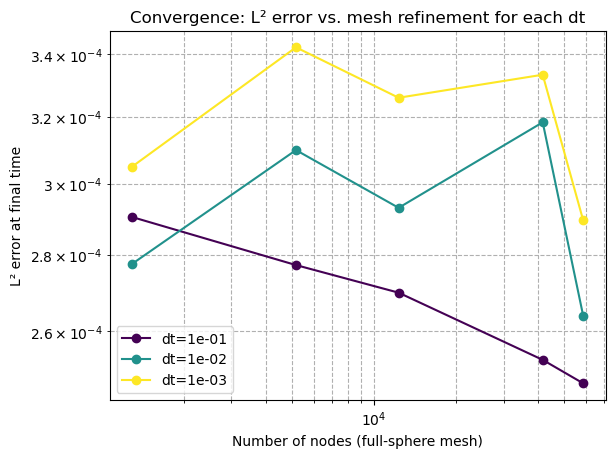

In [15]:

import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
from dolfinx.io import XDMFFile
from dolfinx.fem import (
    Function,
    functionspace,
    create_interpolation_data,
    assemble_scalar,
    form
)
import ufl


mesh_files_dict = dict(mesh_files)
slice_xdmf_dict = dict(slice_mesh_files)


dt_list = [1e-1, 1e-2, 1e-3]
colors = plt.cm.viridis(np.linspace(0, 1, len(dt_list)))

plt.figure()
for idx_dt, dt in enumerate(dt_list):

    ms_list = sorted([ms for (dt2, ms) in results_phi.keys() if dt2 == dt])

    ref_ms = ms_list[0]

    ref_xdmf = slice_xdmf_dict[ref_ms]
    with XDMFFile(MPI.COMM_WORLD, ref_xdmf, "r") as xdmf_ref:
        mesh_ref = xdmf_ref.read_mesh()
    V_ref = functionspace(mesh_ref, ("Lagrange", 1))
    phi_ref_func = Function(V_ref)
    phi_ref_dofs = results_phi[(dt, ref_ms)][-1, :]
    phi_ref_func.x.array[:] = phi_ref_dofs.copy()


    errors_L2 = {}


    for ms in ms_list[1:]:

        coarse_xdmf = slice_xdmf_dict[ms]
        with XDMFFile(MPI.COMM_WORLD, coarse_xdmf, "r") as xdmf_h:
            mesh_h = xdmf_h.read_mesh()
        V_h = functionspace(mesh_h, ("Lagrange", 1))


        tdim_h = mesh_h.topology.dim
        num_cells_h = mesh_h.topology.index_map(tdim_h).size_local
        cells_h = np.arange(num_cells_h, dtype=np.int32)
        interp_data = create_interpolation_data(V_h, V_ref, cells_h)


        phi_ref_on_h = Function(V_h)
        phi_ref_on_h.interpolate_nonmatching(phi_ref_func, cells_h, interp_data)


        phi_h = Function(V_h)
        phi_h_dofs = results_phi[(dt, ms)][-1, :]
        phi_h.x.array[:] = phi_h_dofs.copy()


        full_xdmf = mesh_files_dict[ms]
        with XDMFFile(MPI.COMM_WORLD, full_xdmf, "r") as xdmf_full:
            full_mesh = xdmf_full.read_mesh()
        num_full_nodes = full_mesh.geometry.x.shape[0]


        u_diff = phi_h - phi_ref_on_h
        integrand = form(ufl.inner(u_diff, u_diff) * ufl.ds)
        a = form(integrand, form_compiler_options={"quadrature_degree": 4})
        L2_sq = assemble_scalar(a)
        L2_err = np.sqrt(L2_sq)

        errors_L2[num_full_nodes] = L2_err


    node_counts = sorted(errors_L2.keys(), reverse=True)
    err_list    = [errors_L2[n] for n in node_counts]
    plt.loglog(node_counts, err_list, "-o", color=colors[idx_dt], label=f"dt={dt:.0e}")

plt.xlabel("Number of nodes (full‐sphere mesh)")
plt.ylabel("L² error at final time")
plt.title("Convergence: L² error vs. mesh refinement for each dt")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
from dolfinx.io import XDMFFile
from dolfinx.fem import (
    Function,
    functionspace,
    create_interpolation_data,
    assemble_scalar,
    form
)
import ufl
from matplotlib.ticker import FormatStrFormatter

dt=1e-01 → reference mesh ms=0.013, full‐sphere nodes=88305
dt=1e-02 → reference mesh ms=0.013, full‐sphere nodes=88305
dt=1e-03 → reference mesh ms=0.013, full‐sphere nodes=88305


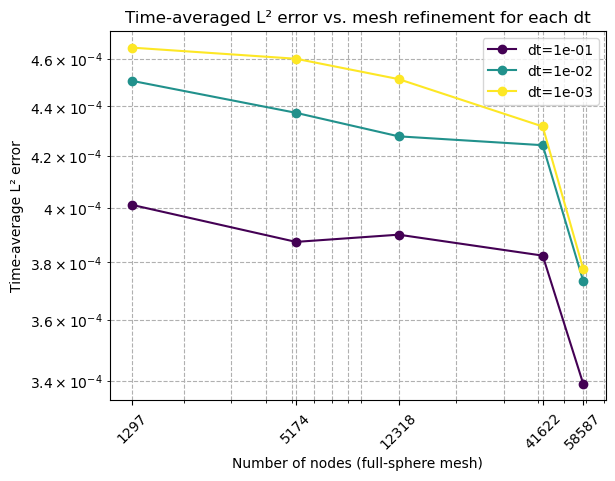

In [21]:

mesh_files_dict = dict(mesh_files)
slice_xdmf_dict = dict(slice_mesh_files)


dt_list = [1e-1, 1e-2, 1e-3]
colors = plt.cm.viridis(np.linspace(0, 1, len(dt_list)))

plt.figure()
for idx_dt, dt in enumerate(dt_list):

    ms_list = sorted([ms for (dt2, ms) in results_phi.keys() if dt2 == dt])
    if len(ms_list) == 0:
        continue


    ref_ms = ms_list[0]



    num_time_steps = results_phi[(dt, ref_ms)].shape[0]


    ref_xdmf = slice_xdmf_dict[ref_ms]
    with XDMFFile(MPI.COMM_WORLD, ref_xdmf, "r") as xdmf_ref:
        mesh_ref = xdmf_ref.read_mesh()
    V_ref = functionspace(mesh_ref, ("Lagrange", 1))


    full_ref_xdmf = mesh_files_dict[ref_ms]
    with XDMFFile(MPI.COMM_WORLD, full_ref_xdmf, "r") as xdmf_full_ref:
        full_mesh_ref = xdmf_full_ref.read_mesh()
    num_full_nodes_ref = full_mesh_ref.geometry.x.shape[0]


    print(f"dt={dt:.0e} => reference mesh ms={ref_ms:.3f}, full‐sphere nodes={num_full_nodes_ref}")


    phi_ref_func = Function(V_ref)


    errors_timeavg = {}


    for ms in ms_list[1:]:

        coarse_xdmf = slice_xdmf_dict[ms]
        with XDMFFile(MPI.COMM_WORLD, coarse_xdmf, "r") as xdmf_h:
            mesh_h = xdmf_h.read_mesh()
        V_h = functionspace(mesh_h, ("Lagrange", 1))


        phi_ref_on_h = Function(V_h)
        phi_h        = Function(V_h)


        full_xdmf = mesh_files_dict[ms]
        with XDMFFile(MPI.COMM_WORLD, full_xdmf, "r") as xdmf_full:
            full_mesh = xdmf_full.read_mesh()
        num_full_nodes = full_mesh.geometry.x.shape[0]


        tdim_h      = mesh_h.topology.dim
        num_cells_h = mesh_h.topology.index_map(tdim_h).size_local
        cells_h     = np.arange(num_cells_h, dtype=np.int32)
        interp_data = create_interpolation_data(V_h, V_ref, cells_h)


        L2_over_time = np.zeros(num_time_steps, dtype=np.float64)
        for n in range(num_time_steps):

            phi_ref_dofs = results_phi[(dt, ref_ms)][n, :]
            phi_ref_func.x.array[:] = phi_ref_dofs.copy()


            phi_ref_on_h.interpolate_nonmatching(phi_ref_func, cells_h, interp_data)


            phi_h_dofs = results_phi[(dt, ms)][n, :]
            phi_h.x.array[:] = phi_h_dofs.copy()


            u_diff    = phi_h - phi_ref_on_h
            integrand = form(ufl.inner(u_diff, u_diff) * ufl.ds)
            a         = form(integrand, form_compiler_options={"quadrature_degree": 4})
            L2_sq     = assemble_scalar(a)
            L2_over_time[n] = np.sqrt(L2_sq)


        timeavg_L2 = np.mean(L2_over_time)
        errors_timeavg[num_full_nodes] = timeavg_L2


    node_counts = sorted(errors_timeavg.keys(), reverse=True)
    err_list    = [errors_timeavg[n] for n in node_counts]
    plt.loglog(node_counts, err_list, "-o", color=colors[idx_dt], label=f"dt={dt:.0e}")


    ax = plt.gca()
    ax.set_xticks(node_counts)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.tick_params(axis="x", rotation=45)

plt.xlabel("Number of nodes (full‐sphere mesh)")
plt.ylabel("Time-average L² error")
plt.title("Time-averaged L² error vs. mesh refinement for each dt")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()